In [1]:
!pip install azure-ai-ml azure identity
!pip install scikit-learn pandas numpy joblib
!pip install azure-storage-blob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 95.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... - error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [25 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-a7sh0r1b/azure_5f43121d3549444d92f6dbfa2e0da492/setup.py", line 60, in <module>
          raise RuntimeError(message)
      RuntimeError:
      
      Starting with v5.0.0, the 'azure' meta-package is deprecated and cannot be installed anymore.
      Please install the service specific packages prefixed by `azure` needed for your application.
      
      The complete list of available packages can be found at:
      https://aka.ms/azsdk/python/all
      
      Here's a non-exhaustive list of common packages:
      
      -  azure-mgmt-com

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import joblib
import os
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Load dataset
data = pd.read_csv("../data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Drop customerID
data = data.drop('customerID', axis=1)

# Convert TotalCharges to numeric
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'] = data['TotalCharges'].fillna(data['TotalCharges'].median())

# Encode categorical variables
for column in data.select_dtypes(include='object').columns:
    data[column] = LabelEncoder().fit_transform(data[column])

# Split data
X = data.drop('Churn', axis=1)
y = data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1] # for ROC-AUC

# 🔹 Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("📊 Model Evaluation Metrics")
print(f"Accuracy: {accuracy:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Save model
os.makedirs("../model", exist_ok=True)
joblib.dump(model, "../model/churn_model.pkl")

print("✅ Model trained and saved successfully!")


📊 Model Evaluation Metrics
Accuracy: 0.796
ROC-AUC: 0.837

Confusion Matrix:
 [[945  91]
 [197 176]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1036
           1       0.66      0.47      0.55       373

    accuracy                           0.80      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.78      0.80      0.78      1409

✅ Model trained and saved successfully!


In [6]:
!pip install azure-ai-ml
!pip install azure-identity
!pip install shap matplotlib
!pip install streamlit requests pydantic azure-storage-blob


In [5]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
from azure.ai.ml.entities import Model

ml_client = MLClient(DefaultAzureCredential(), "e835122e-790c-40f9-99c6-98bfd4cdf02d", "Portfolio", "AzurePort")

model = Model(path="../model/churn_model.pkl", name="churn-model", description="Customer churn prediction model")
ml_client.models.create_or_update(model)

Model({'job_name': None, 'intellectual_property': None, 'system_metadata': None, 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'churn-model', 'description': 'Customer churn prediction model', 'tags': {}, 'properties': {}, 'print_as_yaml': False, 'id': '/subscriptions/e835122e-790c-40f9-99c6-98bfd4cdf02d/resourceGroups/Portfolio/providers/Microsoft.MachineLearningServices/workspaces/AzurePort/models/churn-model/versions/5', 'Resource__source_path': '', 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/support-test/code/Users/support/Customer_churn/src', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7add2e4541c0>, 'serialize': <msrest.serialization.Serializer object at 0x7add2e416da0>, 'version': '5', 'latest_version': None, 'path': 'azureml://subscriptions/e835122e-790c-40f9-99c6-98bfd4cdf02d/resourceGroups/Portfolio/workspaces/AzurePort/datastores/workspaceblobstore/paths/LocalUpload/c805fdef3c10

In [6]:
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Environment,
    CodeConfiguration
)
import datetime

endpoint_name = f"churn-endpoint-{datetime.datetime.now().strftime('%m%d%H%M')}"

# Create endpoint
endpoint = ManagedOnlineEndpoint(
    name=endpoint_name,
    description="Predicts customer churn probability",
    auth_mode="key"
)
ml_client.begin_create_or_update(endpoint).result()

# Create environment
env = Environment(
    name="churn-env",
    conda_file="../environment/conda.yaml",
    image="mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04"
)



In [7]:
# Deployment
deployment = ManagedOnlineDeployment(
    name="blue",
    endpoint_name=endpoint_name,
    model=model,
    environment=env,
    code_configuration=CodeConfiguration(code=".", scoring_script="score.py"),
    instance_type="Standard_DS1_v2",
    instance_count=1
)

ml_client.begin_create_or_update(deployment).result()

# Set traffic
endpoint.traffic = {"blue": 100}
ml_client.begin_create_or_update(endpoint).result()



Instance type Standard_DS1_v2 may be too small for compute resources. Minimum recommended compute SKU is Standard_DS3_v2 for general purpose endpoints. Learn more about SKUs here: https://learn.microsoft.com/azure/machine-learning/referencemanaged-online-endpoints-vm-sku-list
Check: endpoint churn-endpoint-10140717 exists
Uploading src (0.65 MBs): 100%|██████████| 649487/649487 [00:00<00:00, 10005384.11it/s]




..........................................................................

HttpResponseError: (ResourceNotReady) User container has crashed or terminated. Please see troubleshooting guide, available here: https://aka.ms/oe-tsg#error-resourcenotready
Code: ResourceNotReady
Message: User container has crashed or terminated. Please see troubleshooting guide, available here: https://aka.ms/oe-tsg#error-resourcenotready

In [37]:
import requests, json

endpoint = ml_client.online_endpoints.get(name=endpoint_name)
scoring_uri = endpoint.scoring_uri
keys = ml_client.online_endpoints.get_keys(name=endpoint_name)
primary_key = keys.primary_key

sample_input = {"data": [[0, 0, 1, 0, 12, 1, 0, 2, 1, 1, 0, 1, 0, 0, 1, 1, 2, 75.5, 1200.25]]}
headers = {"Content-Type": "application/json", "Authorization": f"Bearer {primary_key}"}

response = requests.post(scoring_uri, headers=headers, data=json.dumps(sample_input))
print(response.status_code)
print(response.json())

200
{'error': 'The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()'}


In [22]:
print(X.columns.to_list())
print(len(X.columns))

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']
19


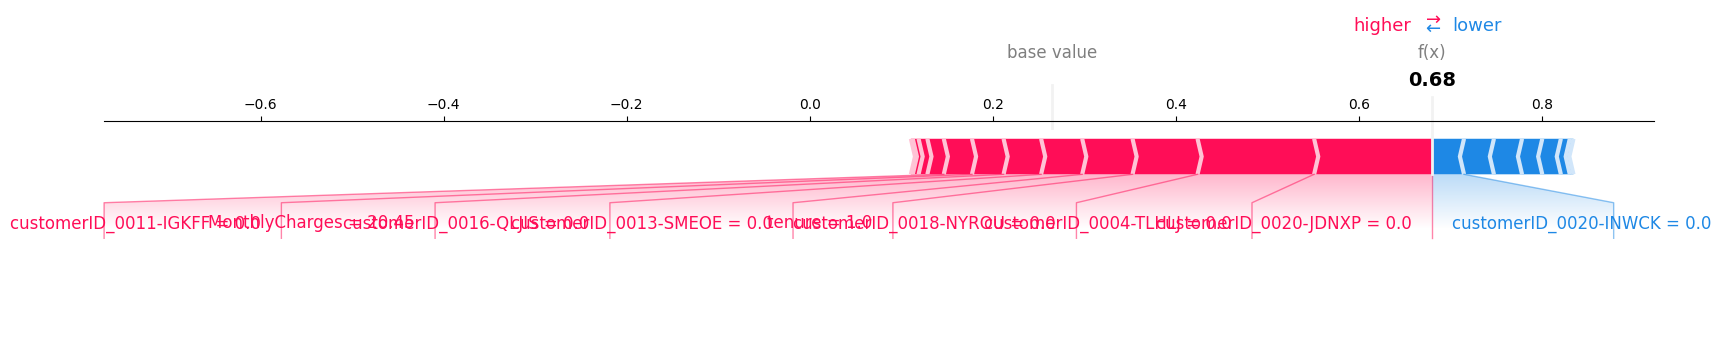

✅ SHAP explainability visualizations saved successfully!


In [4]:
import shap
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# === Load model and data ===
model_path = "../model/churn_model.pkl"
data_path = "../data/WA_Fn-UseC_-Telco-Customer-Churn.csv"

# Load your model and data
trained_model = joblib.load(model_path)
df = pd.read_csv(data_path)

# Separate features and target
X = df.drop(columns=['Churn'])
y = df['Churn']
X = pd.get_dummies(df.drop(columns=['Churn']), drop_first=True)

# Split data (optional)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === SHAP EXPLAINABILITY ===
explainer = shap.TreeExplainer(trained_model)
shap_values = explainer.shap_values(X_test)

# --- SHAP Summary Plot ---
plt.title("Feature Impact on Churn (SHAP Summary)")
shap.summary_plot(shap_values[1], X_test, show=False)
plt.savefig("shap_summary.png", bbox_inches="tight")
plt.close()

# --- SHAP Feature Importance Bar Plot ---
plt.title("Top Features Driving Churn")
shap.summary_plot(shap_values[1], X_test, plot_type="bar", show=False)
plt.savefig("shap_feature_importance.png", bbox_inches="tight")
plt.close()

# --- Individual Prediction Explainability ---
sample_index = 10  # Pick one sample
shap.initjs()

# Generate force plot for a specific prediction
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][sample_index, :],
    X_test.iloc[sample_index, :],
    matplotlib=True
)
plt.savefig("shap_force_plot.png", bbox_inches="tight")
plt.close()

print("✅ SHAP explainability visualizations saved successfully!")
